In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure2 import plotR2YQ2Y, plotMixedClusteringPLSR_GridSearch, plotMeasuredVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.clustering import MassSpecClustering
from msresist.sequence_analysis import preprocess_seqs, FormatName, pYmotifs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean, LinearFoldChange, FoldChangeToControl, MapOverlappingPeptides, BuildMatrix, TripsMeanAndStd, CorrCoefFilter
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

In [2]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', 1000)

## Re-implementation with AXL mutants

### Phosphorylation measurements:

Set *Axlmutants_Erl_F154* or *Axlmutants_Erl* to **True** in order to use these data.

In [3]:
ABC = preprocessing(Axlmutants_Erl_F154=True, motifs=True, Vfilter=True, FCfilter=True, log2T=True)
ABC = preprocess_seqs(ABC, "Y").sort_values(by="Protein")

header = ABC.columns
treatments = ABC.columns[6:]

data = ABC.iloc[:, 6:].T
info = ABC.iloc[:, :6]

In [4]:
ABC.iloc[:10, :]

,Protein,Sequence,UniprotAcc,Position,r2_Std,BioReps,PC9 A,KO A,Kd A,KI A,M4 A,M5 A,M7 A,M10 A,M11 A,M15 A
4,40S ribosomal protein SA ; RPSA,LTEASyVNLPT,P08865,Y139-p,NA,1,-0.905683,-0.264555,0.166887,0.990224,-0.256346,0.239761,-0.126352,0.681401,-0.332600,-0.192736
5,60S ribosomal protein L10a ; RPL10A,SRDTLyEAVRE,P62906,Y11-p,NA,1,0.450394,-0.024163,-0.203233,-0.619397,0.103645,-0.157415,-0.012527,0.406166,0.098905,-0.042375
10,Abl interactor 2 ; ABI2,VVPNDyVPSPT,Q9NYB9,Y213-p,NA,1,0.721179,-1.069889,-0.432169,0.246437,0.267770,0.015784,0.185314,0.205212,0.087689,-0.227328
14,Activated CDC42 kinase 1 ; TNK2,VKKPTyDPVSE,Q07912,Y518-p,NA,1,1.080712,-0.256996,-0.071764,-0.628678,0.221895,-0.335861,0.014586,0.098401,-0.022027,-0.100268
16,Afadin ; AFDN,TYTREyFTFPA,P55196,Y1230-p,NA,1,1.708259,-0.412595,-0.156932,-0.497972,0.261536,-0.059345,0.208678,0.037391,-0.361757,-0.727262
18,Alpha-actinin-1 ; ACTN1,DVAEKyLDIPK,P12814,Y215-p,NA,1,0.593980,-0.727784,0.202174,-0.700101,0.432983,-0.280602,0.197320,0.146372,0.071083,0.064575
20,Annexin A1 ; ANXA1,DARALyEAGER,P04083,Y207-p,NA,1,0.756837,-0.153240,0.094269,0.303752,-0.062449,-0.332210,0.132917,-0.327015,-0.059459,-0.353403
22,Annexin A2 ; ANXA2,GKsLYyYIQQD,P07355,Y317-p,NA,1,-0.440614,0.010714,-0.326594,0.176644,-0.096389,0.678356,0.273878,-0.036524,-0.180260,-0.059211
26,Annexin A2 ; ANXA2,KsYSPyDMLES,P07355,Y238-p,0.85,2,-0.479140,0.163308,0.224061,-0.325695,0.067829,0.221941,0.526361,-0.273107,0.160251,-0.285809
28,"Arf-GAP with Rho-GAP domain, ANK repeat and PH...",FDDSDyDEVPE,Q96P48,Y231-p,NA,1,-0.980710,0.434990,-0.801568,0.432808,0.397934,-0.071515,0.200138,0.237044,-0.098342,0.249220


## Principal Compoenent Analysis

In [5]:
from sklearn.decomposition import PCA

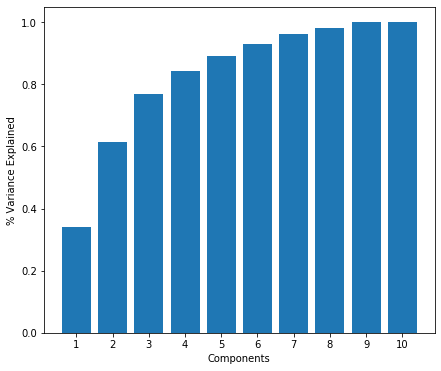

In [6]:
explained = PCA(n_components=10).fit(data.T).explained_variance_ratio_

acc_expl = []
for i, exp in enumerate(explained):
    if i > 0:
        exp+=acc_expl[i-1]
        acc_expl.append(exp)
    else:
        acc_expl.append(exp)

fig, ax = plt.subplots(1, 1, figsize=(7,6))
plt.bar(range(10), acc_expl)
plt.ylabel("% Variance Explained")
plt.xlabel("Components")
plt.xticks(range(10), [i+1 for i in range(10)]);

In [7]:
fit = PCA(n_components=2).fit(data)

In [8]:
PC1_scores = fit.transform(data)[:, 0]
PC2_scores = fit.transform(data)[:, 1]

PC1_loadings = fit.components_[0]
PC2_loadings = fit.components_[1]

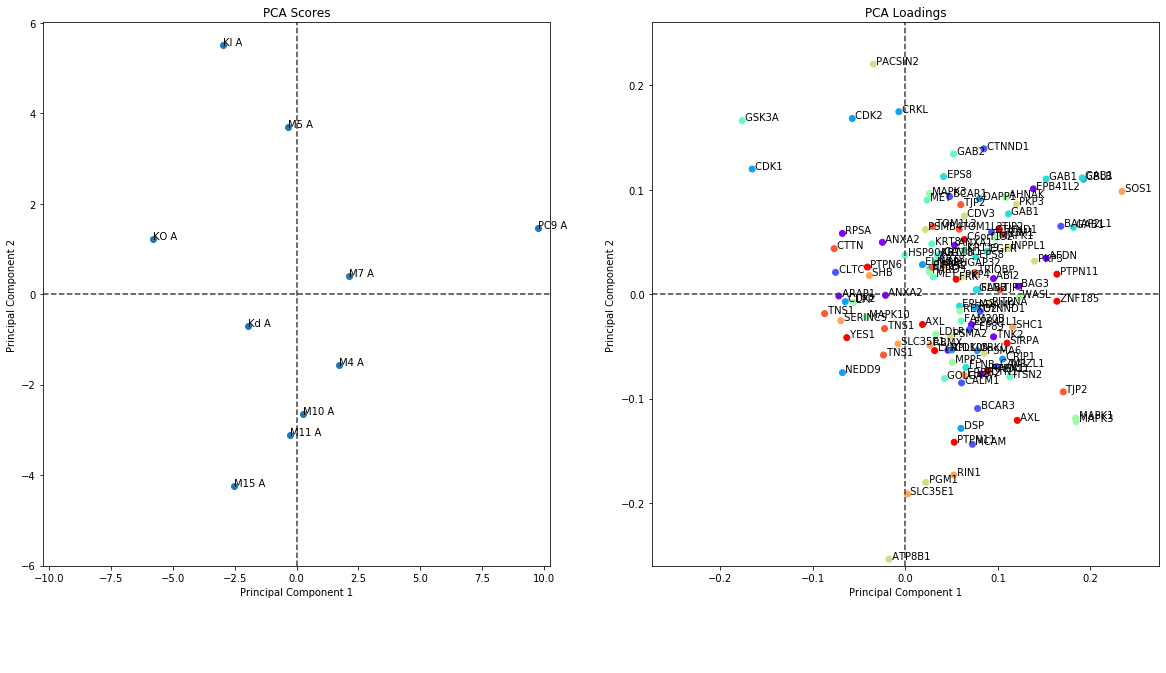

In [9]:
colors_ = cm.rainbow(np.linspace(0, 1, PC1_scores.size))

# Scores
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].scatter(PC1_scores, PC2_scores)
for j, txt in enumerate(list(ABC.columns)[6:]):
    ax[0].annotate(txt, (PC1_scores[j], PC2_scores[j]))
ax[0].set_title('PCA Scores')
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')
ax[0].axhline(y=0, color='0.25', linestyle='--')
ax[0].axvline(x=0, color='0.25', linestyle='--')

spacer = 0.5
ax[0].set_xlim([(-1 * max(PC1_scores)) - spacer, max(PC1_scores) + spacer])
ax[0].set_ylim([(-1 * max(PC2_scores)) - spacer, max(PC2_scores) + spacer])

# Loadings
for i, txt in enumerate(list(ABC.iloc[:, 0])):
    ax[1].annotate(txt.split(";")[1], (PC1_loadings[i], PC2_loadings[i]))
ax[1].scatter(PC1_loadings, PC2_loadings, c=np.arange(PC1_loadings.size), cmap=colors.ListedColormap(colors_))
ax[1].set_title('PCA Loadings')
ax[1].set_xlabel('Principal Component 1')
ax[1].set_ylabel('Principal Component 2')
ax[1].axhline(y=0, color='0.25', linestyle='--')
ax[1].axvline(x=0, color='0.25', linestyle='--')
spacer = 0.04
ax[1].set_xlim([(-1 * max(PC1_loadings) - spacer), (max(PC1_loadings) + spacer)])
ax[1].set_ylim([(-1 * max(PC2_loadings) - spacer), (max(PC2_loadings) + spacer)]);

### Phenotypes

#### Cell Viability (from luminex...):

In [10]:
Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/101819-CellTiterGlo_AxlMutants_F154_BR1_raw.csv')
# Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/101819-CellTiterGlo_AxlMutants_F154_BR1_raw.csv').T

Y_cv = Y_cv.iloc[:, 0:10].div(Y_cv.iloc[:, 0], axis=0).T

# Y_cv = Y_cv.iloc[:, 0:10].sub(Y_cv.iloc[:, 0:10].mean(axis=1), axis=0).T

# Chained MS mixed clustering + PLSR analysis

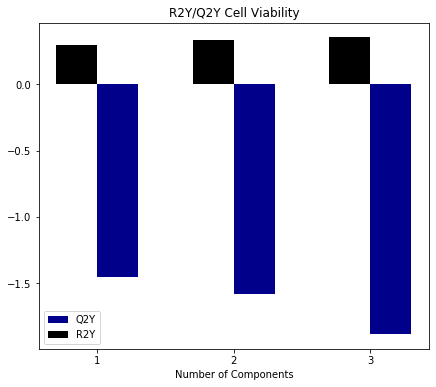

In [11]:
ncl = 3
GMMweight = 0

MSC = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="Binomial").fit(data, Y_cv)
centers = MSC.transform(data)

fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, ncl, centers, Y_cv)

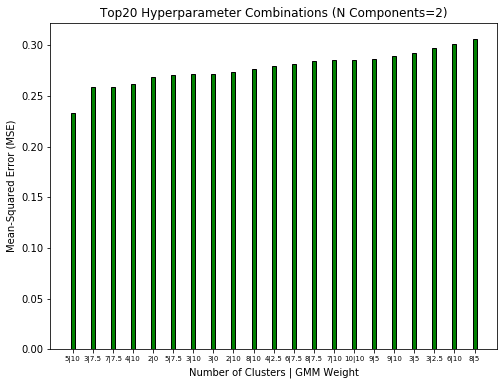

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
plotMixedClusteringPLSR_GridSearch(ax, data, info, Y_cv)

In [13]:
ncomp = 2

mixedCl_plsr = Pipeline([('mixedCl', MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="Binomial")), ('plsr', PLSRegression(ncomp))])
fit = mixedCl_plsr.fit(data, Y_cv)

In [14]:
# fig, ax = plt.subplots(1,1,figsize=(6,5))
# plotMeasuredVsPredicted(ax, mixedCl_plsr, data, Y_cv)

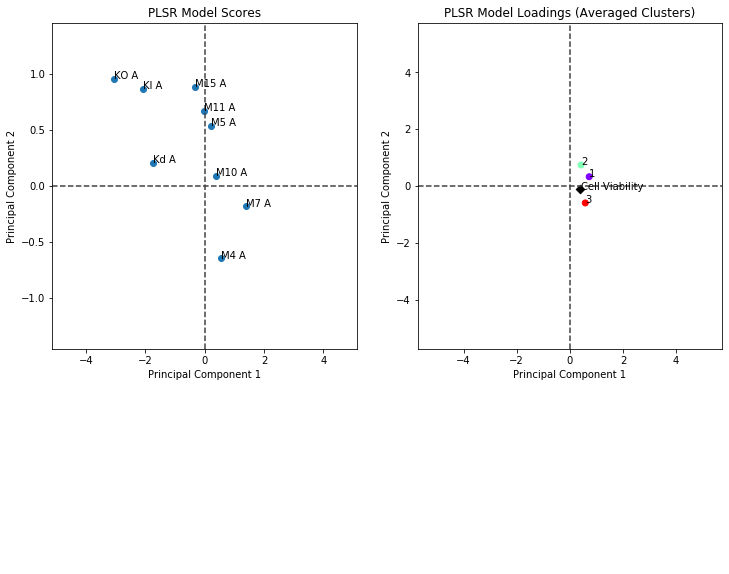

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
colors_ = cm.rainbow(np.linspace(0, 1, ncl))

plotScoresLoadings(ax, fit, centers, Y_cv, ncl, colors_, treatments)

In [16]:
clustermembers = mixedCl_plsr.named_steps.mixedCl.clustermembers(ABC.T)
clustermembers.iloc[:10, :]

,Cluster_1,seqs_Cluster_1,UniprotAcc_Cluster_1,pos_Cluster_1,r2/Std_Cluster_1,BioReps_Cluster_1,Cluster_2,seqs_Cluster_2,UniprotAcc_Cluster_2,pos_Cluster_2,r2/Std_Cluster_2,BioReps_Cluster_2,Cluster_3,seqs_Cluster_3,UniprotAcc_Cluster_3,pos_Cluster_3,r2/Std_Cluster_3,BioReps_Cluster_3
0,60S ribosomal protein L10a ; RPL10A,SRDTLyEAVRE,P62906,Y11-p,NA,1,40S ribosomal protein SA ; RPSA,LTEASyVNLPT,P08865,Y139-p,NA,1,Annexin A2 ; ANXA2,GKsLYyYIQQD,P07355,Y317-p,NA,1
1,Cell surface glycoprotein MUC18 ; MCAM,DQGEKyIDLRH,P43121,Y641-p,NA,1,Abl interactor 2 ; ABI2,VVPNDyVPSPT,Q9NYB9,Y213-p,NA,1,Annexin A2 ; ANXA2,KsYSPyDMLES,P07355,Y238-p,0.85,2
2,Clathrin heavy chain 1 ; CLTC,ITEEDyQALRT,Q00610,Y1477-p,NA,1,Activated CDC42 kinase 1 ; TNK2,VKKPTyDPVSE,Q07912,Y518-p,NA,1,Catenin delta-1 ; CTNND1,GGSDNyGSLSR,O60716,Y228-p,NA,1
3,Crk-like protein ; CRKL,RVPCAyDKTAL,P46109,Y251-p,NA,1,Afadin ; AFDN,TYTREyFTFPA,P55196,Y1230-p,NA,1,Catenin delta-1 ; CTNND1,SRQDVyGPQPQ,O60716,Y257-p,NA,1
4,Cyclin-dependent kinase-like 5 ; CDKL5,ANYTEyVATRW,O76039,Y171-p,NA,1,Alpha-actinin-1 ; ACTN1,DVAEKyLDIPK,P12814,Y215-p,NA,1,Cyclin-dependent kinase 1 ; CDK1,IGEGTyGVVYK,P06493,Y15-p,0.99,2
5,Cysteine-rich protein 1 ; CRIP1,CNKEVyFAERV,P50238,Y12-p,NA,1,Annexin A1 ; ANXA1,DARALyEAGER,P04083,Y207-p,NA,1,Cyclin-dependent kinase 2 ; CDK2,IGEGTyGVVYK,P24941,Y15-p,0.47,3
6,Dual adapter for phosphotyrosine and 3-phospho...,EEPSIyESVRV,Q9UN19,Y139-p,NA,1,"Arf-GAP with Rho-GAP domain, ANK repeat and PH...",FDDSDyDEVPE,Q96P48,Y231-p,NA,1,Cyclin-dependent kinase 2 ; CDK2,IGEGtyGVVYK,P24941,Y15-p,NA,1
7,Engulfment and cell motility protein 2 ; ELMO2,LPNPEyYTLRY,Q96JJ3,Y48-p,NA,1,BAG family molecular chaperone regulator 3 ; ...,AQQGEyQTHQP,O95817,Y240-p,NA,1,Desmoplakin ; DSP,QPELKyGDGIQ,P15924,Y95-p,NA,1
8,GRB2-associated-binding protein 1 ; GAB1,VDSSLyNLPRS,Q13480,Y259-p,NA,1,Band 4.1-like protein 1 ; EPB41L1,IRPGEyEQFES,Q9H4G0,Y343-p,NA,1,Eukaryotic translation initiation factor 2 sub...,KDTRLyFLQCE,P20042,Y298-p,NA,1
9,GRB2-associated-binding protein 1 ; GAB1,SSQDCyDIPRA,Q13480,Y406-p,0.93,2,Band 4.1-like protein 2 ; EPB41L2,EGDNIyVRHSN,O43491,Y623-p,0.68,2,Filamin-B ; FLNB,IDNYDySHTVK,O75369,Y904-p,NA,1


In [17]:
create_download_link(clustermembers, "DataClustering")

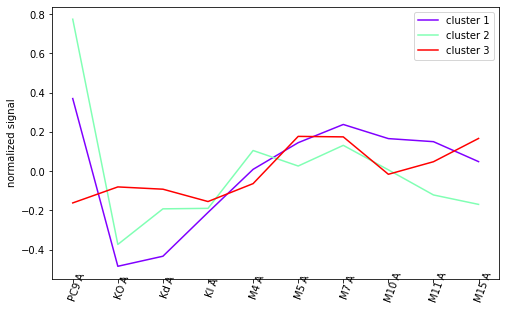

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclusteraverages(ax, ABC, mixedCl_plsr, colors_)